In [1]:
# Import necessary libraries
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import itertools


file_path_train = r"C:\Users\user\Desktop\bitirme_projesi\card_transdata_part1.csv"
file_path_test = r"C:\Users\user\Desktop\bitirme_projesi\card_transdata_part2.csv"

df_train = pd.read_csv(file_path_train)
df_test = pd.read_csv(file_path_test)

In [2]:
# Separate features and target
X_train = df_train.drop("fraud", axis=1)
y_train = df_train["fraud"]
X_test = df_test.drop("fraud", axis=1)
y_test = df_test["fraud"]

# Standardize feature values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Class distribution before SMOTE:")
print(pd.Series(y_train).value_counts())

Class distribution before SMOTE:
fraud
0.0    456298
1.0     43702
Name: count, dtype: int64


In [3]:
# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())


Class distribution after SMOTE:
fraud
0.0    456298
1.0    456298
Name: count, dtype: int64


In [4]:
# Initialize XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

xgb_model.fit(X_train_resampled, y_train_resampled)

C:\Users\user\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:15:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [5]:
y_pred = xgb_model.predict(X_test_scaled)
y_prob = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("--- Model Evaluation ---")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
print("\nROC AUC:", roc_auc_score(y_test, y_prob))

--- Model Evaluation ---
Confusion Matrix:
 [[455602    697]
 [   149  43552]]

Classification Report:
               precision    recall  f1-score   support

         0.0     0.9997    0.9985    0.9991    456299
         1.0     0.9842    0.9966    0.9904     43701

    accuracy                         0.9983    500000
   macro avg     0.9920    0.9975    0.9947    500000
weighted avg     0.9983    0.9983    0.9983    500000


ROC AUC: 0.9999851530706307


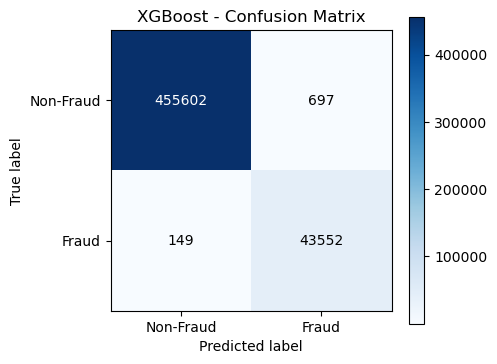

In [6]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
classes = ["Non-Fraud", "Fraud"]

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=classes,
    yticklabels=classes,
    ylabel="True label",
    xlabel="Predicted label",
    title="XGBoost - Confusion Matrix"
)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    ax.text(j, i, format(cm[i, j], "d"),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


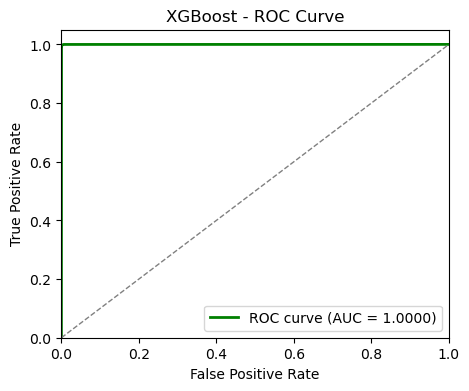

In [7]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color="green", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="grey", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost - ROC Curve")
plt.legend(loc="lower right")
plt.show()


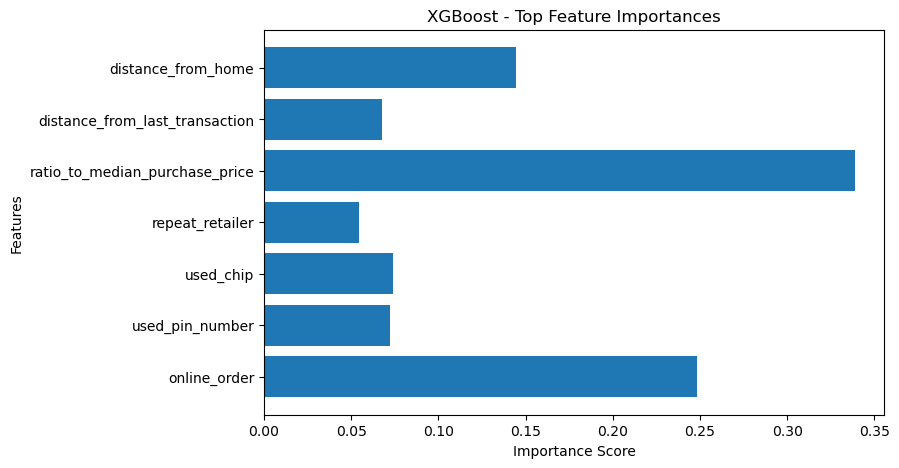

In [8]:
# Feature importance
importances = xgb_model.feature_importances_
features = X_train.columns

plt.figure(figsize=(8, 5))
plt.barh(features[:15], importances[:15])  # ilk 15 ən önəmli xüsusiyyət
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("XGBoost - Top Feature Importances")
plt.gca().invert_yaxis()
plt.show()
